In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
os.chdir('..')
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import TrackerCallback
from fastai.callbacks import CSVLogger
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from utils.mxresnet import *
from utils.ranger import *
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [2]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [3]:
FOLD = 0
NAME = 'EXP_60'
SUFFIX =f'EFF_NET_CL2_{FOLD}'
PATH = Path('../../../bengaliai')
SZ = 224
BS = 256
NFOLDS = 5 #keep the same split as the initial dataset
SEED = 2019
TRAIN_IMG = PATH/'img_trn_224'
LABELS = PATH/'train.csv'

os.chdir(NAME)

In [4]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def multi_strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [5]:
df = pd.read_csv(str(LABELS))
nunique = list(df.nunique())[1:-1]

In [6]:
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]].get_values())[FOLD]

/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  """Entry point for launching an IPython kernel.


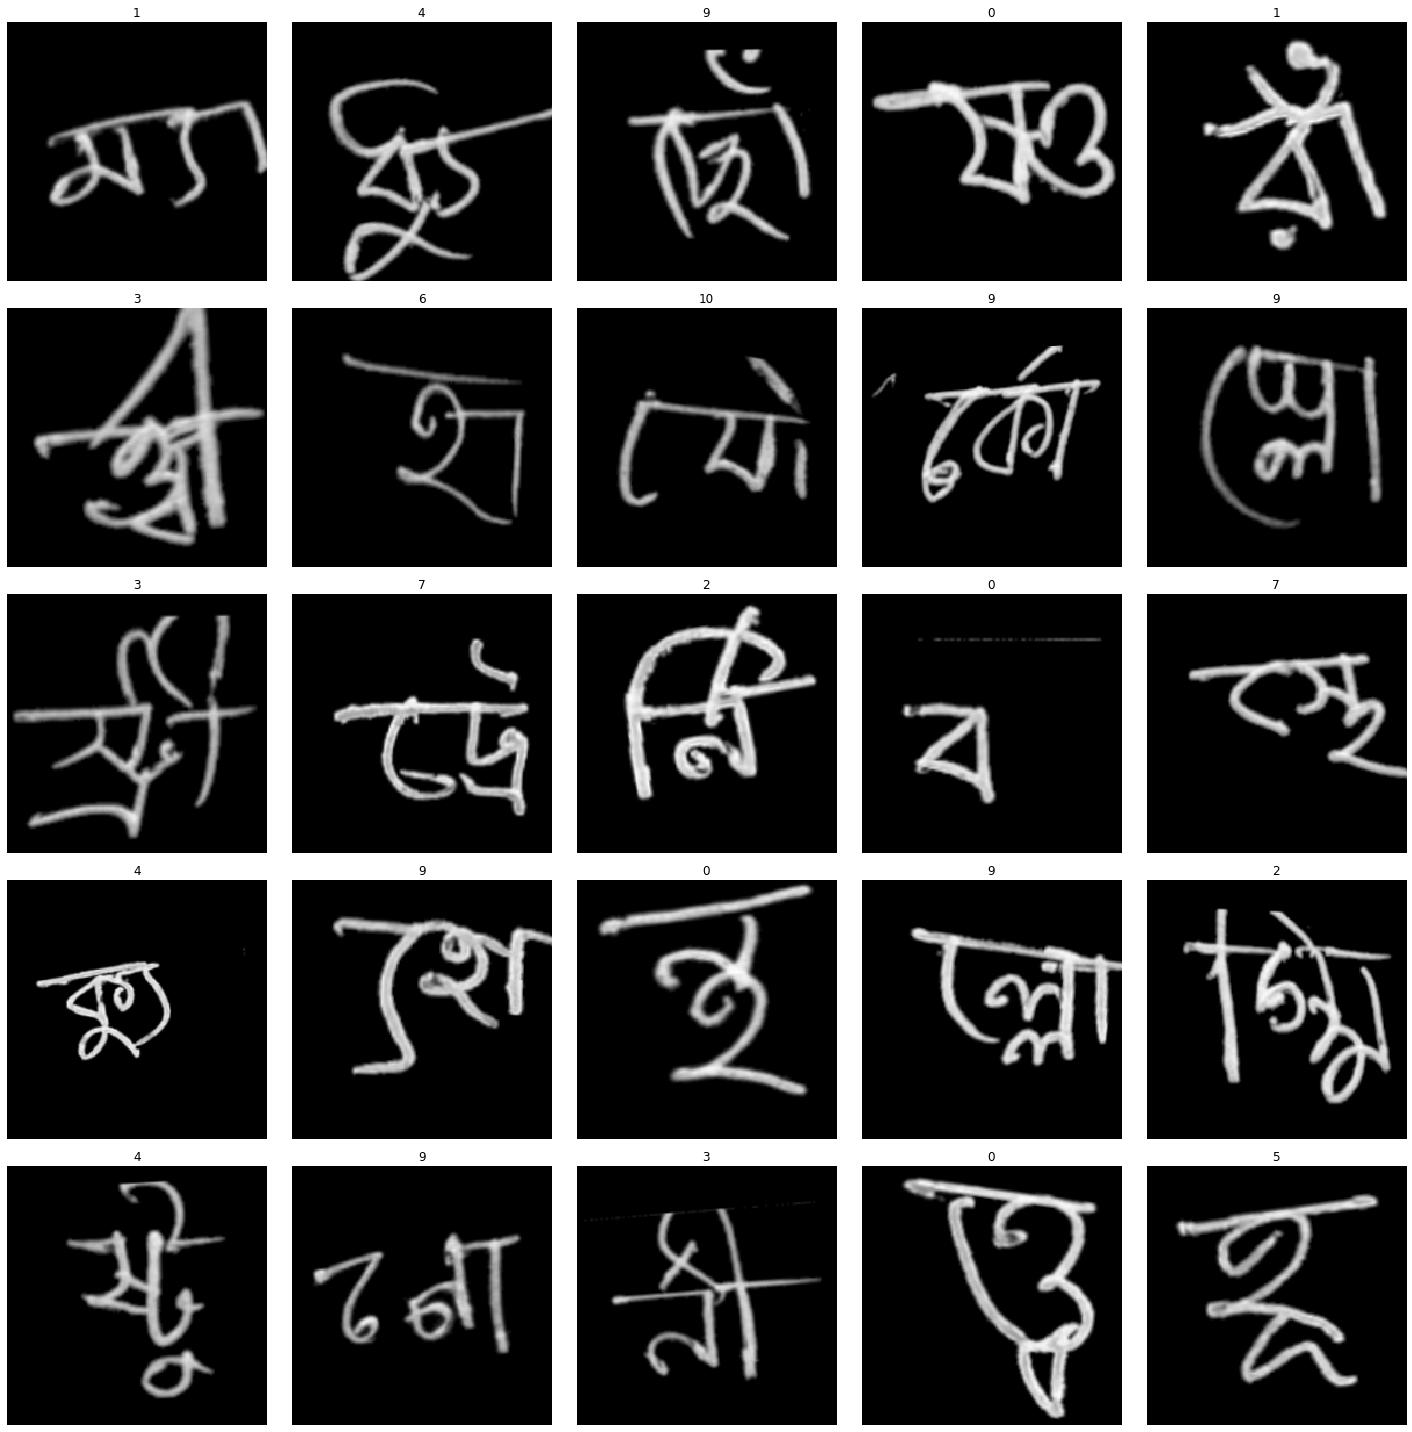

In [7]:
#imagenet_stats
data = (ImageList.from_df(df, path='', folder=TRAIN_IMG, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols=['vowel_diacritic']) #','consonant_diacritic'
        .transform(get_transforms(do_flip=False,max_warp=0.1, max_zoom=1.2), size=SZ, padding_mode='zeros')
        .databunch(bs=BS)).normalize(imagenet_stats)

data.show_batch()

In [8]:
stats_ = data.stats
stats_

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [9]:
class Metric_idx(Callback):
    def __init__(self, average='macro'):
        super().__init__()
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output
        last_target = last_target
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx)

In [10]:
md_ef =  EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.c) 

Loaded pretrained weights for efficientnet-b0


In [11]:

learn = Learner(data, md_ef,
        metrics=[Metric_grapheme()])
learn.model = nn.DataParallel(learn.model)

learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,metric_idx,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


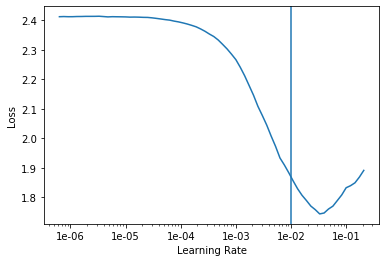

In [12]:
lr = 1e-2
learn.recorder.plot(skip_end=10)
plt.axvline(lr)

In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, wd=1e-2,
                    callbacks = [SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{NAME}_{SUFFIX}_{FOLD}')])

epoch,train_loss,valid_loss,metric_idx,time
0,0.197636,1.946747,0.550541,04:03
1,0.196350,2.498321,0.659352,04:03
2,0.162252,0.428476,0.889628,04:03
3,0.132608,0.277257,0.883620,04:02
4,0.116051,0.153862,0.928851,04:03
5,0.093004,0.097822,0.964517,04:03
6,0.077423,0.080983,0.963589,04:02
7,0.053164,0.062081,0.975426,04:03
8,0.042600,0.056401,0.980863,04:03
9,0.036940,0.056013,0.981375,04:02


Better model found at epoch 0 with valid_loss value: 1.9467467069625854.
Better model found at epoch 2 with valid_loss value: 0.4284757971763611.
Better model found at epoch 3 with valid_loss value: 0.2772566080093384.
Better model found at epoch 4 with valid_loss value: 0.15386202931404114.
Better model found at epoch 5 with valid_loss value: 0.09782177954912186.
Better model found at epoch 6 with valid_loss value: 0.08098308742046356.
Better model found at epoch 7 with valid_loss value: 0.0620805099606514.
Better model found at epoch 8 with valid_loss value: 0.05640149116516113.
Better model found at epoch 9 with valid_loss value: 0.05601298063993454.
